# Checking waveforms with lalsimulation

For safely using `tiwave`, we need to make sure every detail of implemented waveforms is consistent with `lalsimulation`. Here we check waveforms in three aspects. 

We first check waveforms using a test case arbitrarily chosen. We first compare values of ansatz coefficients. And then we plot the built waveforms for comparing the difference visually. In some models, the waveform construction is slightly adjusted for different area of parameter space. To cover every pieces, we compute the mismatch of waveforms at samples drawn randomly in the allowed parameters space of the model.

In [1]:
from functools import partial

import lal
import lalsimulation as lalsim
import bilby
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

%matplotlib inline
fig_width_pt = 3 * 246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0 / 72.27  # Convert pt to inch
golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Aesthetic ratio
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width * golden_mean  # height in inches
fig_size = [fig_width, fig_height]
plot_params = {
    "axes.labelsize": 24,
    "font.family": "serif",
    "font.serif": "Computer Modern Raman",
    "font.size": 28,
    "legend.fontsize": 24,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "axes.grid": True,
    "text.usetex": True,
    "savefig.dpi": 500,
    "lines.markersize": 18,
    "figure.figsize": fig_size,
}
matplotlib.rcParams.update(plot_params)

# TODO: improving the installation
import sys

sys.path.append("/home/hydrogen/workspace/Space_GW/tiwave")

import taichi as ti

ti.init(arch=ti.cpu, default_fp=ti.f64, offline_cache=False, cpu_max_num_threads=1)

/tmp/ipykernel_1580400/2190446171.py:3: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


[Taichi] version 1.7.2, llvm 15.0.4, commit 0131dce9, linux, python 3.10.12


[I 03/06/25 15:14:57.661 1580400] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


[Taichi] Starting on arch=x64


In [2]:
reference_frequency = 20.0
minimum_frequency = 20.0
maximum_frequency = 2048.0
sampling_rate = 4096
duration = 32.0

num_samples = int(duration * sampling_rate)
full_freqs = np.fft.rfftfreq(num_samples, 1 / sampling_rate)
freqs_mask = (full_freqs <= maximum_frequency) * (full_freqs >= minimum_frequency)
freqs = full_freqs[freqs_mask]
delta_f = freqs[1] - freqs[0]
freqs_ti = ti.field(ti.f64, shape=freqs.shape)
freqs_ti.from_numpy(freqs)

# tolerence
tolerance_abs = 1.0e-8
tolerance_rel = 1.0e-10


def is_equal(lal_value, tiw_value, name):
    if not lal_value == 0.0:
        err_abs = lal_value - tiw_value
        err_rel = (lal_value - tiw_value) / lal_value
        ret = (err_abs < tolerance_abs) and (err_rel < tolerance_rel)
    else:
        err_abs = lal_value - tiw_value
        err_rel = None
        ret = err_abs < tolerance_abs

    print(name)
    print("lalsim: ", lal_value, "tiwave: ", tiw_value)
    print("err abs: ", err_abs, "err rel: ", err_rel)
    print(ret)

    return ret


# psd_array = np.ones(shape=freqs.shape)
PSD_Aplus = bilby.gw.detector.PowerSpectralDensity(asd_file="Aplus_asd.txt")
psd_array = PSD_Aplus.get_power_spectral_density_array(freqs)


def normalising(hf, psd_array, delta_f):
    return hf / np.sqrt(
        bilby.gw.utils.noise_weighted_inner_product(hf, hf, psd_array, 1 / delta_f).real
    )


def mismatch_core(h1_norm, h2_norm, psd_array, delta_f):
    return (
        1.0
        - bilby.gw.utils.noise_weighted_inner_product(
            h1_norm, h2_norm, psd_array, 1 / delta_f
        ).real
    )


def mismatch(
    mass_1,
    mass_2,
    chi_1,
    chi_2,
    luminosity_distance,
    inclination,
    reference_phase,
    tiw_wf_func,
    lal_wf_func,
    psd_array,
    delta_f,
):

    wf_tiw = tiw_wf_func(
        mass_1,
        mass_2,
        chi_1,
        chi_2,
        luminosity_distance,
        inclination,
        reference_phase,
    )
    wf_lal = lal_wf_func(
        mass_1,
        mass_2,
        chi_1,
        chi_2,
        luminosity_distance,
        inclination,
        reference_phase,
    )

    hp_norm_tiw = normalising(wf_tiw["hplus"], psd_array, delta_f)
    hc_norm_tiw = normalising(wf_tiw["hcross"], psd_array, delta_f)
    hp_norm_lal = normalising(wf_lal["hplus"], psd_array, delta_f)
    hc_norm_lal = normalising(wf_lal["hcross"], psd_array, delta_f)

    return (
        mismatch_core(hp_norm_tiw, hp_norm_lal, psd_array, delta_f),
        mismatch_core(hc_norm_tiw, hc_norm_lal, psd_array, delta_f),
    )

In [3]:
# fmt: off
def show_waveform_comparison(waveform_tiw, waveform_lal):
    
    fig, axs = plt.subplots(4, 2, figsize=[fig_width * 2, fig_height * 4])

    axs[0, 0].set_title("Amplitude")
    axs[0, 0].loglog(freqs, np.abs(waveform_tiw["hplus"]), label="tiwave")
    axs[0, 0].loglog(freqs, np.abs(waveform_lal["hplus"]), linestyle="dashed", label="lalsim")
    axs[0, 0].set_xlim(minimum_frequency, maximum_frequency)
    axs[0, 0].set_xlabel("Frequency (Hz)")
    axs[0, 0].set_ylabel(r"$|h_+|$")
    axs[0, 0].legend()

    axs[0, 1].set_title("Amplitude")
    axs[0, 1].loglog(freqs, np.abs(waveform_tiw["hcross"]), label="tiwave")
    axs[0, 1].loglog(freqs, np.abs(waveform_lal["hcross"]), linestyle="dashed", label="lalsim")
    axs[0, 1].set_xlim(minimum_frequency, maximum_frequency)
    axs[0, 1].set_xlabel("Frequency (Hz)")
    axs[0, 1].set_ylabel(r"$|h_\times|$")
    axs[0, 1].legend()

    axs[1, 0].set_title("Real part")
    axs[1, 0].semilogx(freqs, waveform_tiw["hplus"].real, label="tiwave")
    axs[1, 0].semilogx(freqs, waveform_lal["hplus"].real, linestyle="dashed", label="lalsim")
    axs[1, 0].set_xlim(minimum_frequency, maximum_frequency)
    axs[1, 0].set_xlabel("Frequency (Hz)")
    axs[1, 0].set_ylabel(r"$h_+^{\rm Re}$")
    axs[1, 0].legend()

    axs[1, 1].set_title("Real part")
    axs[1, 1].semilogx(freqs, waveform_tiw["hcross"].real, label="tiwave")
    axs[1, 1].semilogx(freqs, waveform_lal["hcross"].real, linestyle="dashed", label="lalsim")
    axs[1, 1].set_xlim(minimum_frequency, maximum_frequency)
    axs[1, 1].set_xlabel("Frequency (Hz)")
    axs[1, 1].set_ylabel(r"$h_\times^{\rm Re}$")
    axs[1, 1].legend()

    axs[2, 0].set_title("Imaginary part")
    axs[2, 0].semilogx(freqs, waveform_tiw["hplus"].imag, label="tiwave")
    axs[2, 0].semilogx(freqs, waveform_lal["hplus"].imag, linestyle="dashed", label="lalsim")
    axs[2, 0].set_xlim(minimum_frequency, maximum_frequency)
    axs[2, 0].set_xlabel("Frequency (Hz)")
    axs[2, 0].set_ylabel(r"$h_+^{\rm Im}$")
    axs[2, 0].legend()

    axs[2, 1].set_title("Imaginary part")
    axs[2, 1].semilogx(freqs, waveform_tiw["hcross"].imag, label="tiwave")
    axs[2, 1].semilogx(freqs, waveform_lal["hcross"].imag, linestyle="dashed", label="lalsim")
    axs[2, 1].set_xlim(minimum_frequency, maximum_frequency)
    axs[2, 1].set_xlabel("Frequency (Hz)")
    axs[2, 1].set_ylabel(r"$h_\times^{\rm Im}$")
    axs[2, 1].legend()

    axs[3, 0].set_title("Difference")
    axs[3, 0].loglog(freqs, np.abs(waveform_tiw["hplus"] - waveform_lal["hplus"]))
    axs[3, 0].set_xlim(minimum_frequency, maximum_frequency)
    axs[3, 0].set_xlabel("Frequency (Hz)")
    axs[3, 0].set_ylabel(r"$|h_+^{\rm tiwave} - h_+^{\rm lalsim}|$")

    axs[3, 1].set_title("Difference")
    axs[3, 1].loglog(freqs, np.abs(waveform_tiw["hcross"] - waveform_lal["hcross"]))
    axs[3, 1].set_xlim(minimum_frequency, maximum_frequency)
    axs[3, 1].set_xlabel("Frequency (Hz)")
    axs[3, 1].set_ylabel(r"$|h_\times^{\rm tiwave} - h_\times^{\rm lalsim}|$")

    fig.tight_layout()
    fig.show()
# fmt: on

In [4]:
# an arbitrarily chosen test case
parameters = dict(
    mass_1=36.0,
    mass_2=29.0,
    chi_1=-0.4,
    chi_2=0.02,
    luminosity_distance=800.0,
    inclination=0.4,
    reference_phase=1.2,
)

## IMRPhenomD

## IMRPhenomXAS

- Comparing values of coefficients in the waveform ansatz

In [5]:
from tiwave.waveforms import IMRPhenomXAS

xas_tiw = IMRPhenomXAS(freqs_ti, reference_frequency)
xas_tiw.update_waveform(parameters)

/home/hydrogen/workspace/Space_GW/tiwave/tiwave/waveforms/base_waveform.py:45: UserWarning: check_parameters is disable, make sure all parameters passed in are valid.
  warnings.warn(


In [6]:
# values of ansatz coefficients given by lalsimlation
# setting CFLAGS='-g -D PHENOMXHMDEBUG' to obtain the debug information

# using default configuration
# Inspiral Amp Version      : 103
# Intermediate Amp Version  : 104
# Ringdown Amp Version      : 103

# Inspiral Phase Version        : 104
# Intermediate Phase Version    : 105
# Ringdown Phase Version        : 105

# phase coefficients
lalsim_XAS_coeffs_phase = dict(
    # inspiral
    pn_phi0=1.0000000000000000e00,
    pn_phi1=0.0000000000000000e00,
    pn_phi2=1.3779841169305184e01,
    pn_phi3=-1.7933661579771422e02,
    pn_phi4=2.0122909161443940e02,
    pn_phi5=0.0000000000000000e00,
    pn_phi6=-1.6199727883136980e04,
    pn_phi7=3.0704777032881244e04,
    pn_phi8=2.0488988904432222e03,
    pn_phi5l=1.4103375172207761e03,
    pn_phi6l=-1.0728103323596813e03,
    pn_phi8l=1.4156709088924592e04,
    ins_a0=-1.2559580256860478e04,
    ins_a1=3.1430403649084282e05,
    ins_a2=-4.8479183822615136e05,
    ins_a3=-1.0353446809946555e06,
    # intermediate
    int_b0=-3.3240287669887664e01,
    int_b1=-5.6647349547531487e00,
    int_b2=2.9996549097364633e-01,
    int_b3=-5.1558188989106850e-03,
    int_b4=4.0595492463932989e-05,
    # merge-ringdown
    MRD_c0=-4.1355092775620896e01,
    MRD_c1=-2.5867019814145003e01,
    MRD_c2=1.3880539241153048e-01,
    MRD_c4=-6.8605062875088936e-05,
    MRD_cL=-3.6257425875162686e-03,
    # connection conditions
    C0_int=1.7918077676584005e01,
    C1_int=4.2632564145606011e-14,
    C0_MRD=3.8197416973029668e01,
    C1_MRD=4.6685996352340453e-01,
    # time and phase shift
    linb=2.9910171154608679e02,
    phifRef=-8.5126647519295858e01,
    # joint frequency
    fPhaseMatchIN=1.8103321600837271e-02,
    fPhaseMatchIM=4.8757024630749296e-02,
)
# amplitude coefficients
lalsim_XAS_coeffs_amp = dict(
    # inspiral
    A2=-1.6701560621633178e00,
    A3=-1.9839269143253400e00,
    A4=-2.1413435529985417e01,
    A5=-1.8346767804579585e01,
    A6=-4.1562282579462995e01,
    ins_alpha1=2.4373597823426589e00,
    ins_alpha2=-1.2885037133169333e04,
    ins_alpha3=5.1995528782820737e04,
    # intermediate
    int_delta0=2.6824399290321672e-03,
    int_delta1=1.6474779937163808e-01,
    int_delta2=3.6480625205557487e01,
    int_delta3=-8.0466024177036797e02,
    int_delta4=5.1991385440590884e03,
    # merge-ringdown
    MRD_gamma1=1.6254892668290152e-02,
    MRD_gamma2=8.2259850887065455e-01,
    MRD_gamma3=1.3076726769239482e00,
    # joint frequency
    fAmpIN=2.4097267483853609e-02,
    fAmpIM=7.2641868507279592e-02,
)

In [7]:
# fmt: off
# PN coefficients
pn_phi_tiw_lal = 1/(-3/(128 * np.pi**(5/3) * xas_tiw.source_parameters[None].eta))
is_equal(lalsim_XAS_coeffs_phase["pn_phi0"], xas_tiw.pn_coefficients[None].phi_0*pn_phi_tiw_lal, "pn phi0")
is_equal(lalsim_XAS_coeffs_phase["pn_phi1"], xas_tiw.pn_coefficients[None].phi_1*pn_phi_tiw_lal, "pn phi1")
is_equal(lalsim_XAS_coeffs_phase["pn_phi2"], xas_tiw.pn_coefficients[None].phi_2*pn_phi_tiw_lal, "pn phi2")
is_equal(lalsim_XAS_coeffs_phase["pn_phi3"], xas_tiw.pn_coefficients[None].phi_3*pn_phi_tiw_lal, "pn phi3")
is_equal(lalsim_XAS_coeffs_phase["pn_phi4"], xas_tiw.pn_coefficients[None].phi_4*pn_phi_tiw_lal, "pn phi4")
is_equal(lalsim_XAS_coeffs_phase["pn_phi6"], (xas_tiw.pn_coefficients[None].phi_6 + xas_tiw.pn_coefficients[None].phi_6l*np.log(np.pi))*pn_phi_tiw_lal, "pn phi6")
is_equal(lalsim_XAS_coeffs_phase["pn_phi7"], xas_tiw.pn_coefficients[None].phi_7*pn_phi_tiw_lal, "pn phi7")
is_equal(lalsim_XAS_coeffs_phase["pn_phi8"], (xas_tiw.pn_coefficients[None].phi_8 + xas_tiw.pn_coefficients[None].phi_8l*np.log(np.pi))*pn_phi_tiw_lal, "pn phi8")
is_equal(lalsim_XAS_coeffs_phase["pn_phi5l"], xas_tiw.pn_coefficients[None].phi_5l*pn_phi_tiw_lal, "pn phi5l")
is_equal(lalsim_XAS_coeffs_phase["pn_phi6l"], xas_tiw.pn_coefficients[None].phi_6l*pn_phi_tiw_lal, "pn phi6l")
is_equal(lalsim_XAS_coeffs_phase["pn_phi8l"], xas_tiw.pn_coefficients[None].phi_8l*pn_phi_tiw_lal, "pn phi8l")
is_equal(1.0, xas_tiw.pn_coefficients[None].A_0, "pn A_0")
is_equal(0.0, xas_tiw.pn_coefficients[None].A_1, "pn A_1")
is_equal(lalsim_XAS_coeffs_amp["A2"], xas_tiw.pn_coefficients[None].A_2, "pn A_2")
is_equal(lalsim_XAS_coeffs_amp["A3"], xas_tiw.pn_coefficients[None].A_3, "pn A_3")
is_equal(lalsim_XAS_coeffs_amp["A4"], xas_tiw.pn_coefficients[None].A_4, "pn A_4")
is_equal(lalsim_XAS_coeffs_amp["A5"], xas_tiw.pn_coefficients[None].A_5, "pn A_5")
is_equal(lalsim_XAS_coeffs_amp["A6"], xas_tiw.pn_coefficients[None].A_6, "pn A_6")

# Phase coefficients
sigma_to_a = 1/(5/(128*np.pi**(5/3)*xas_tiw.source_parameters[None].eta))
is_equal(lalsim_XAS_coeffs_phase["ins_a0"], xas_tiw.phase_coefficients[None].sigma_1*sigma_to_a, "phase ins_a0")
is_equal(lalsim_XAS_coeffs_phase["ins_a1"], xas_tiw.phase_coefficients[None].sigma_2*sigma_to_a, "phase ins_a1")
is_equal(lalsim_XAS_coeffs_phase["ins_a2"], xas_tiw.phase_coefficients[None].sigma_3*sigma_to_a, "phase ins_a2")
is_equal(lalsim_XAS_coeffs_phase["ins_a3"], xas_tiw.phase_coefficients[None].sigma_4*sigma_to_a, "phase ins_a3")

beta_to_b = xas_tiw.source_parameters[None].eta
is_equal(lalsim_XAS_coeffs_phase["int_b0"], xas_tiw.phase_coefficients[None].beta_0*beta_to_b, "phase int_b0")
is_equal(lalsim_XAS_coeffs_phase["int_b1"], xas_tiw.phase_coefficients[None].beta_1*beta_to_b, "phase int_b1")
is_equal(lalsim_XAS_coeffs_phase["int_b2"], xas_tiw.phase_coefficients[None].beta_2*beta_to_b, "phase int_b2")
is_equal(lalsim_XAS_coeffs_phase["int_b3"], xas_tiw.phase_coefficients[None].beta_3*beta_to_b, "phase int_b3")
is_equal(lalsim_XAS_coeffs_phase["int_b4"], xas_tiw.phase_coefficients[None].beta_4*beta_to_b, "phase int_b4")

c_tiw_lal = xas_tiw.source_parameters[None].eta
is_equal(lalsim_XAS_coeffs_phase["MRD_c0"], xas_tiw.phase_coefficients[None].c_0*c_tiw_lal, "phase MRD_c0")
is_equal(lalsim_XAS_coeffs_phase["MRD_c1"], xas_tiw.phase_coefficients[None].c_1*c_tiw_lal, "phase MRD_c1")
is_equal(lalsim_XAS_coeffs_phase["MRD_c2"], xas_tiw.phase_coefficients[None].c_2*c_tiw_lal, "phase MRD_c2")
is_equal(lalsim_XAS_coeffs_phase["MRD_c4"], xas_tiw.phase_coefficients[None].c_4*c_tiw_lal, "phase MRD_c4")
is_equal(lalsim_XAS_coeffs_phase["MRD_cL"], xas_tiw.phase_coefficients[None].c_L*c_tiw_lal, "phase MRD_cL")

cc_tiw_lal = xas_tiw.source_parameters[None].eta
is_equal(lalsim_XAS_coeffs_phase["C0_int"], xas_tiw.phase_coefficients[None].C0_int*cc_tiw_lal, "phase C0_int")
is_equal(0.0, xas_tiw.phase_coefficients[None].C1_int*cc_tiw_lal, "phase C1_int")
is_equal(lalsim_XAS_coeffs_phase["C0_MRD"], xas_tiw.phase_coefficients[None].C0_MRD*cc_tiw_lal, "phase C0_MRD")
is_equal(lalsim_XAS_coeffs_phase["C1_MRD"], xas_tiw.phase_coefficients[None].C1_MRD*cc_tiw_lal, "phase C1_MRD")

is_equal(lalsim_XAS_coeffs_phase["linb"], xas_tiw.phase_coefficients[None].time_shift, "time shift")
is_equal(lalsim_XAS_coeffs_phase["phifRef"], xas_tiw.phase_coefficients[None].phase_shift, "phase shift")

is_equal(lalsim_XAS_coeffs_phase["fPhaseMatchIN"], xas_tiw.phase_coefficients[None].fjoin_int_ins, "phase fjoin int ins")
is_equal(lalsim_XAS_coeffs_phase["fPhaseMatchIM"], xas_tiw.phase_coefficients[None].fjoin_MRD_int, "phase fjoin MRD int")

# Amplitude coefficients
is_equal(lalsim_XAS_coeffs_amp["ins_alpha1"], xas_tiw.amplitude_coefficients[None].rho_1, "amp psuedo PN 1")
is_equal(lalsim_XAS_coeffs_amp["ins_alpha2"], xas_tiw.amplitude_coefficients[None].rho_2, "amp psuedo PN 2")
is_equal(lalsim_XAS_coeffs_amp["ins_alpha3"], xas_tiw.amplitude_coefficients[None].rho_3, "amp psuedo PN 3")

is_equal(lalsim_XAS_coeffs_amp["int_delta0"], xas_tiw.amplitude_coefficients[None].alpha_0, "amp int 0")
is_equal(lalsim_XAS_coeffs_amp["int_delta1"], xas_tiw.amplitude_coefficients[None].alpha_1, "amp int 1")
is_equal(lalsim_XAS_coeffs_amp["int_delta2"], xas_tiw.amplitude_coefficients[None].alpha_2, "amp int 2")
is_equal(lalsim_XAS_coeffs_amp["int_delta3"], xas_tiw.amplitude_coefficients[None].alpha_3, "amp int 3")
is_equal(lalsim_XAS_coeffs_amp["int_delta4"], xas_tiw.amplitude_coefficients[None].alpha_4, "amp int 4")

is_equal(lalsim_XAS_coeffs_amp["MRD_gamma1"], xas_tiw.amplitude_coefficients[None].gamma_1, "amp MRD gamma1")
is_equal(lalsim_XAS_coeffs_amp["MRD_gamma2"], xas_tiw.amplitude_coefficients[None].gamma_2, "amp MRD gamma2")
is_equal(lalsim_XAS_coeffs_amp["MRD_gamma3"], xas_tiw.amplitude_coefficients[None].gamma_3, "amp MRD gamma3")

is_equal(lalsim_XAS_coeffs_amp["fAmpIN"], xas_tiw.amplitude_coefficients[None].fjoin_int_ins, "amp fjoin_int_ins")
is_equal(lalsim_XAS_coeffs_amp["fAmpIM"], xas_tiw.amplitude_coefficients[None].fjoin_MRD_int, "amp fjoin_MRD_int")
# fmt: on

pn phi0
lalsim:  1.0 tiwave:  1.0000000000000002
err abs:  -2.220446049250313e-16 err rel:  -2.220446049250313e-16
True
pn phi1
lalsim:  0.0 tiwave:  -0.0
err abs:  0.0 err rel:  None
True
pn phi2
lalsim:  13.779841169305184 tiwave:  13.779841169305184
err abs:  0.0 err rel:  0.0
True
pn phi3
lalsim:  -179.33661579771422 tiwave:  -179.33661579771427
err abs:  5.684341886080802e-14 err rel:  -3.1696493550946405e-16
True
pn phi4
lalsim:  201.2290916144394 tiwave:  201.2290916144393
err abs:  8.526512829121202e-14 err rel:  4.237216776517702e-16
True
pn phi6
lalsim:  -16199.72788313698 tiwave:  -16199.727883136979
err abs:  -1.8189894035458565e-12 err rel:  1.1228518260725378e-16
True
pn phi7
lalsim:  30704.777032881244 tiwave:  30704.77703288123
err abs:  1.4551915228366852e-11 err rel:  4.739300081151361e-16
True
pn phi8
lalsim:  2048.898890443222 tiwave:  2048.89889044322
err abs:  2.2737367544323206e-12 err rel:  1.1097359489225263e-15
True
pn phi5l
lalsim:  1410.3375172207761 tiwave:

True

- comparing the waveform visually

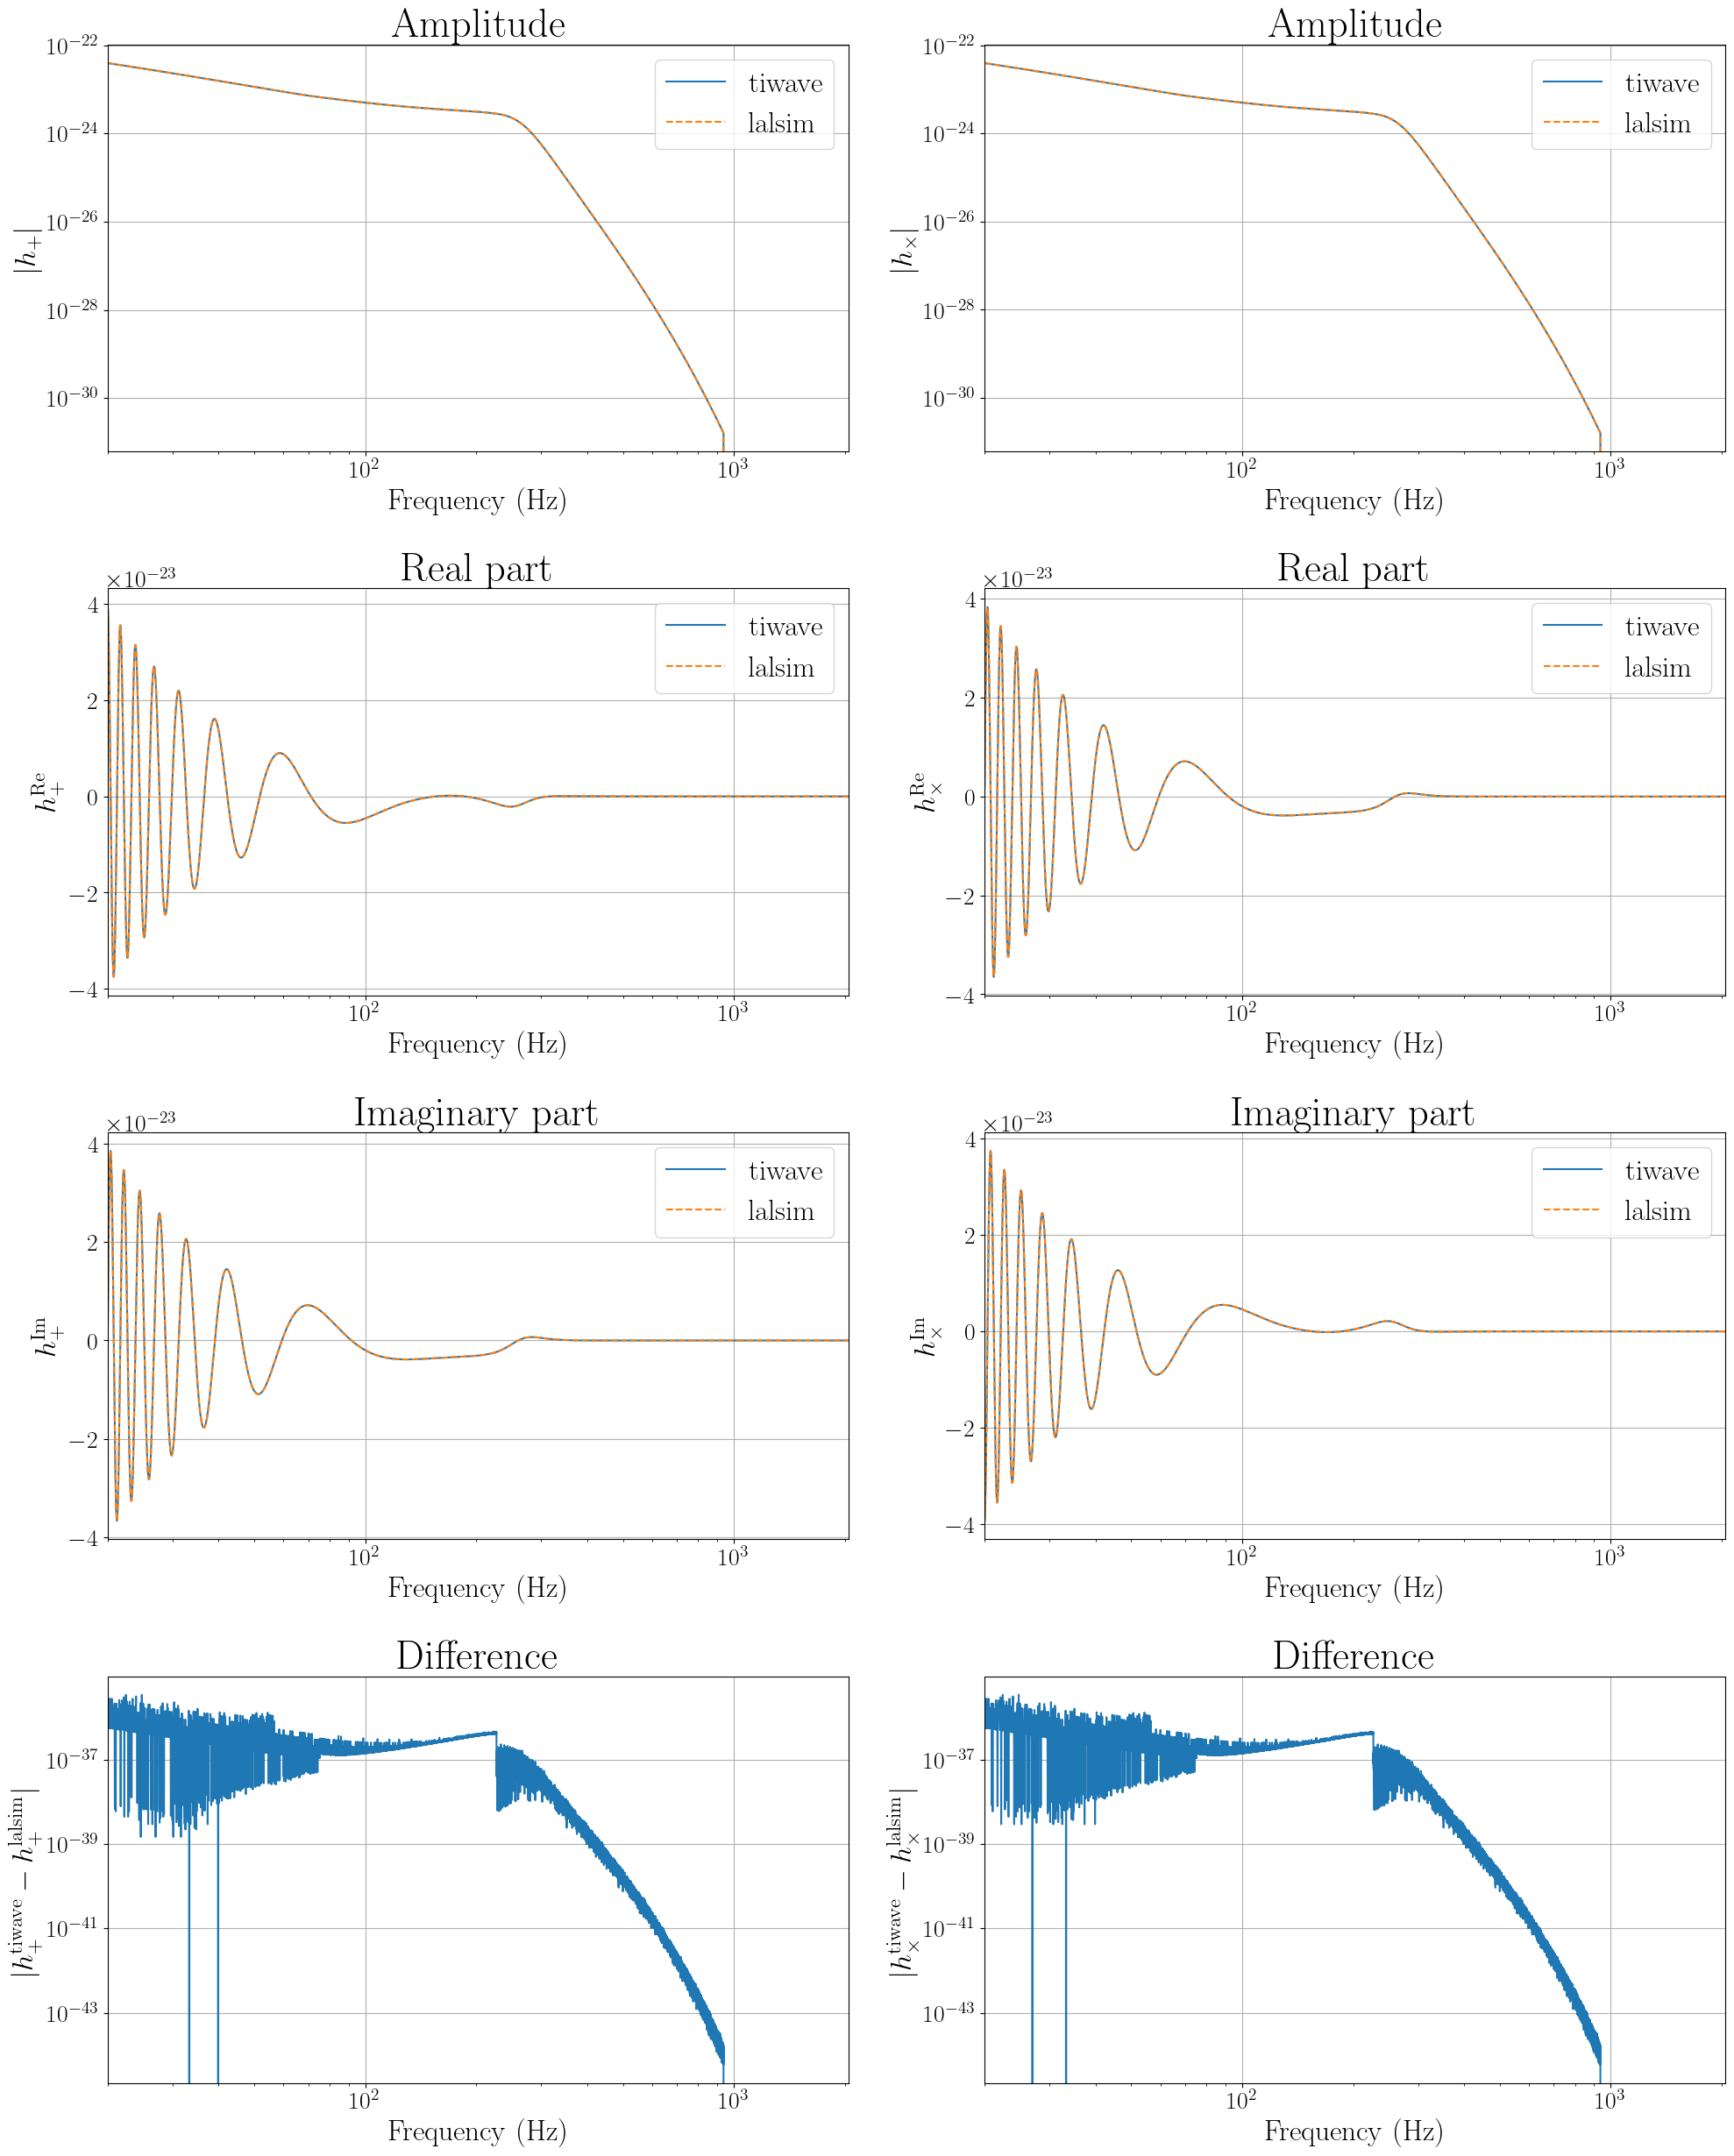

In [8]:
appro_xas = lalsim.GetApproximantFromString("IMRPhenomXAS")
extra_params = lal.CreateDict()
freqs_lal = lal.CreateREAL8Vector(len(freqs))
freqs_lal.data = freqs

hp_lal, hc_lal = lalsim.SimInspiralChooseFDWaveformSequence(
    float(parameters["reference_phase"]),
    float(parameters["mass_1"] * lal.MSUN_SI),
    float(parameters["mass_2"] * lal.MSUN_SI),
    float(0.0),
    float(0.0),
    float(parameters["chi_1"]),
    float(0.0),
    float(0.0),
    float(parameters["chi_2"]),
    float(reference_frequency),
    float(parameters["luminosity_distance"] * 1e6 * lal.PC_SI),
    float(parameters["inclination"]),
    extra_params,
    appro_xas,
    freqs_lal,
)

show_waveform_comparison(
    xas_tiw.waveform_container_numpy,
    {"hplus": hp_lal.data.data, "hcross": hc_lal.data.data},
)

- Mismatch in the whole parameter space

In [9]:
def xas_tiw_wrapper(
    mass_1,
    mass_2,
    chi_1,
    chi_2,
    luminosity_distance,
    inclination,
    reference_phase,
):
    params_in = {
        "mass_1": mass_1,
        "mass_2": mass_2,
        "chi_1": chi_1,
        "chi_2": chi_2,
        "luminosity_distance": luminosity_distance,
        "inclination": inclination,
        "reference_phase": reference_phase,
    }
    xas_tiw.update_waveform(params_in)
    return xas_tiw.waveform_container_numpy


def xas_lal_wrapper(
    mass_1,
    mass_2,
    chi_1,
    chi_2,
    luminosity_distance,
    inclination,
    reference_phase,
):
    hp, hc = lalsim.SimInspiralChooseFDWaveformSequence(
        float(reference_phase),
        float(mass_1 * lal.MSUN_SI),
        float(mass_2 * lal.MSUN_SI),
        float(0.0),
        float(0.0),
        float(chi_1),
        float(0.0),
        float(0.0),
        float(chi_2),
        float(reference_frequency),
        float(luminosity_distance * 1e6 * lal.PC_SI),
        float(inclination),
        extra_params,
        appro_xas,
        freqs_lal,
    )
    return {"hplus": hp.data.data, "hcross": hc.data.data}


mismatch_xas = partial(
    mismatch,
    tiw_wf_func=xas_tiw_wrapper,
    lal_wf_func=xas_lal_wrapper,
    psd_array=psd_array,
    delta_f=delta_f,
)

In [10]:
rng = np.random.default_rng(seed=20250305)
num = 10000
samples = {}
samples["total_mass"] = rng.uniform(20, 250, num)
# XAS model is calibrated to mass ratio from 1 to 1000, using log-uniform to cover more case with extreme mass ratio
samples["mass_ratio"] = 10 ** rng.uniform(-3, 0, num)
samples["chi_1"] = rng.uniform(-0.99, 0.99, num)
samples["chi_2"] = rng.uniform(-0.99, 0.99, num)
samples["luminosity_distance"] = parameters["luminosity_distance"] * np.ones(num)
# samples['luminosity_distance'] = rng.uniform(20, 1000, num) * np.ones(num)
samples["cos_iota"] = rng.uniform(-1, 1, num)
samples["inclination"] = np.arccos(samples["cos_iota"])
samples["reference_phase"] = rng.uniform(0, 2 * np.pi, num)
samples = bilby.gw.conversion.generate_component_masses(samples)

mism = list(
    map(
        mismatch_xas,
        samples["mass_1"],
        samples["mass_2"],
        samples["chi_1"],
        samples["chi_2"],
        samples["luminosity_distance"],
        samples["inclination"],
        samples["reference_phase"],
    )
)
mism = np.array(mism)

In [11]:
print("Mismatch of the test case: ", mismatch_xas(**parameters))

Mismatch of the test case:  (-2.220446049250313e-16, 0.0)


The maximum mismatch in samples is:  6.661338147750939e-16


The maximum mismatch in samples is:  -6.661338147750939e-16


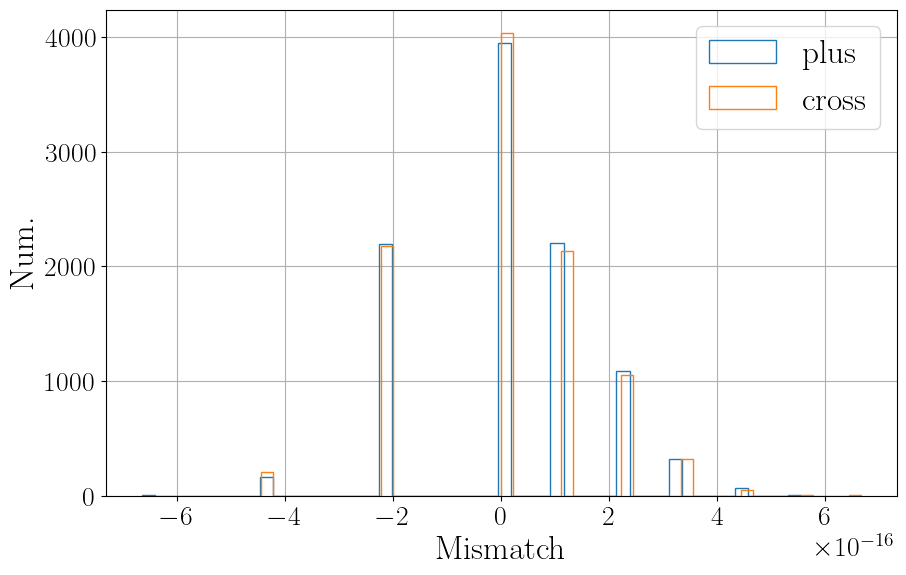

In [12]:
print("The maximum mismatch in samples is: ", mism.max())
print("The maximum mismatch in samples is: ", mism.min())

fig, ax = plt.subplots()
ax.hist(
    mism[:, 0],
    bins=50,
    histtype="step",
    label="plus",
)
ax.hist(
    mism[:, 1],
    bins=50,
    histtype="step",
    label="cross",
)
ax.set_xlabel("Mismatch")
ax.set_ylabel("Num.")
ax.legend()
fig.show()

## IMRPhenomXHM

## IMRPhenomXPHM